In [14]:
import torch
import lightning.pytorch as pl
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import Dict, List, Any
from PIL import Image
from torchvision.transforms import ToTensor, Compose, Normalize
import torch.nn.functional as F
import numpy as np
import random
from torch.nn import Conv2d, BatchNorm2d, ReLU, MaxPool2d, Sequential, Sigmoid, Upsample, ModuleList, LeakyReLU, Linear
from lightning.pytorch import seed_everything
import matplotlib.pyplot as plt

# DERMGAN   

Paper abstract:
Despite the recent success in applying supervised deep learning to medical imaging tasks, the problem of obtaining large and diverse expert-annotated datasets required for the development of high performant models remains particularly challenging. In this work, we explore the possibility of using Generative Adverserial Networks (GAN) to synthesize clinical images with skin condition. We propose DermGAN, an adaptation of the popular Pix2Pix architecture, to create synthetic images for a pre-specified skin condition while being able to vary its size, location and the underlying skin color. We demonstrate that the generated images are of high fidelity using objective GAN evaluation metrics. In a Human Turing test, we note that the synthetic images are not only visually similar to real images, but also embody the respective skin condition in dermatologists' eyes. Finally, when using the synthetic images as a data augmentation technique for training a skin condition classifier, we observe that the model performs comparably to the baseline model overall while improving on rare but malignant conditions. 

DermGAN, as the name suggests, is a Generative Adversarial Network based on the Pix2Pix architecture.  
The contributions brought forth by this paper mostly deal with how to more effectively let the model learn the properties of medical images detailing skin conditions, through custom losses which allow the model to focus on the important parts of each image.

## Dataset creation

Our dataset is made up of image-color mask pairs.  
The objective of the model is to learn the mapping from the latter to the former.

In [2]:
from typing import Any

class MaskPairDataset(Dataset):
    def __init__(self, base_folder : Path, transforms = None, img_norm: Normalize = None, mask_norm: Normalize=None, suffix:str = "_mask", is_mask_rgb:bool = False):
        self.transforms = transforms
        self.img_norm = img_norm
        self.mask_norm = mask_norm
        self.is_mask_rgb = is_mask_rgb

        # Get all png images in the folder
        img_list = base_folder.glob("*.png")
        # Remove the masks
        img_list = [img for img in img_list if "mask" not in img.name]
        # Create the pairs
        self.paired_data = []
        for img in img_list:
            supposed_mask = base_folder / (img.stem + suffix + ".png")
            if supposed_mask.is_file():
                self.paired_data.append((img, supposed_mask))
    
    def __len__(self) -> int:
        return len(self.paired_data)
    
    def __getitem__(self, index) -> Dict:
        img_path, mask_path = self.paired_data[index]
        img = Image.open(img_path).convert("RGB")
        if self.is_mask_rgb:
            mask = Image.open(mask_path).convert("RGB")
        else:
            mask = Image.open(mask_path).convert("L")

        # Apply transforms
        if self.transforms is not None:
            # Make sure that random transforms to both image and mask behave in the same way
            seed = np.random.randint(2147483647) 

            random.seed(seed) 
            torch.manual_seed(seed)
            img = self.transforms(img)

            random.seed(seed) 
            torch.manual_seed(seed)
            mask = self.transforms(mask)
        if self.mask_norm is not None:
            mask = self.mask_norm(mask)
        if self.img_norm is not None:
            img = self.img_norm(img)       
        img = img *2-1 # Scale in [-1,1]     
        return {"img":img, "mask":mask}


def pair_collate_fn(batches : List)-> Dict:
    keys = batches[0].keys()
    return {k:torch.stack([b[k] for b in batches], dim=0) for k in keys}


In [3]:
# Building the dataset and dataloader
base_folder = Path("D:\\crops")
dataset = MaskPairDataset(base_folder, transforms=ToTensor(), suffix="_mask2", is_mask_rgb=True)#, img_norm=Normalize(mean=means, std=stds), mask_norm=Normalize(mean=[0.5], std=[0.5]))


## Building the network

### Base building blocks
Both the generator as well as the discriminator are comprised of multiple convolutional blocks stacked one after the other.  
In the DermGAN paper a block is comprised of a convolutional layer, a batch normalization one and a ReLU activation.  
Apparently a leaky ReLU activation is preferable for Pix2Pix so I chose that one as the output activation.
Furthermore they don't specify what the Up and Down blocks of the generator are made up of, so I went for a classical Maxpooling for the downward block and a NN upsampling plus convolution for the upward one.

In [4]:
# Common building blocks
class ConvBlock(torch.nn.Module):

    def __init__(self, in_channels:int, out_channels:int = None, 
                 kernel_size:int=3, residual: bool = False) -> None:
        super().__init__()        
        if out_channels is None:
            out_channels = in_channels
        self.residual = residual

        self.conv = Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding="same")
        self.bn = BatchNorm2d(out_channels)
    
    def forward(self, input):
        x1 = self.conv(input)
        x = self.bn(x1)
        if self.residual:
            x = x + x1
        return LeakyReLU()(x)

class Down(torch.nn.Module):
    def __init__(self, downscaling:int = 2) -> None:
        super().__init__()
        self.maxpool = MaxPool2d(downscaling)
    
    def forward(self, input):
        return self.maxpool(input)

class Up(torch.nn.Module):
    def __init__(self, in_channels:int, upscaling:int = 2) -> None:
        super().__init__()
        self.up = Upsample(scale_factor=upscaling, mode="nearest")
        self.conv = Conv2d(in_channels, in_channels//upscaling, kernel_size=3, padding="same")
        
    def forward(self, input):
        x = self.up(input)
        x = self.conv(x)
        return x

### Generator
The generator amounts to a model which given an image (a color mask) is supposed to output a skin-condition-riddled image.  
To do so we need an image-to-image architecture, and a Unet is the perfect candidate for it.  
The output activation is a $tanh$, to obtain values in the $[-1,1]$ range, the same range as the input values.

In [5]:
# Generator
class DermGen(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, blocks_per_level:int, 
                 level_channel_sizes: List[int]):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.blocks_per_level = blocks_per_level
        self.level_channel_sizes = level_channel_sizes
        
        # Input and output convolutions, to adapt to inner Unet dimensions
        self.in_conv = ConvBlock(self.in_channels, self.level_channel_sizes[0])
        
        self.out_conv = Sequential(
            Conv2d(self.level_channel_sizes[0], self.out_channels, kernel_size=3, padding="same"),
            BatchNorm2d(self.out_channels)
        )

        # Instantiate intermediate blocks of the unet 
        self.n_levels = len(self.level_channel_sizes)-1
        self.down_blocks = ModuleList()
        self.up_blocks = ModuleList()
        for l in range(self.n_levels):
            d = ModuleList()
            for i in range(self.blocks_per_level):
                if i == 0 and l != 0:
                    d.append(ConvBlock(in_channels=self.level_channel_sizes[l-1], 
                                       out_channels=self.level_channel_sizes[l],))
                else:
                    d.append(ConvBlock(self.level_channel_sizes[l]))
            
            u = ModuleList([
                ConvBlock(self.level_channel_sizes[l]) for i in range(self.blocks_per_level)])
            self.down_blocks.append(d)
            self.up_blocks.append(u)
        # Bottom of the unet
        bottom = []
        for i in range(self.blocks_per_level):
            if i == 0:
                bottom.append(ConvBlock(in_channels=self.level_channel_sizes[-2], 
                                    out_channels=self.level_channel_sizes[-1],))
            else:
                bottom.append(ConvBlock(self.level_channel_sizes[-1]))
        self.bottom = Sequential(*bottom)

        # Instantiate up and down operations
        self.downs = ModuleList([Down() for i in range(self.n_levels)])
        self.ups = ModuleList([Up(self.level_channel_sizes[i+1]) for i in range(self.n_levels)])

    def forward(self, input):
        # z = torch.empty_like(input).normal_(mean=0, std=1) # If you want to add randomness
        x = self.in_conv(input)
        # Unet down
        level_activations = []
        for lev in range(self.n_levels):
            for block in self.down_blocks[lev]:
                x = block(x)
            level_activations.append(x)

            x = self.downs[lev](x)

        # Bottom level
        x = self.bottom(x)

        # Unet up
        for lev in reversed(range(self.n_levels)):
            x = self.ups[lev](x)
            # Skip connection
            x = x + level_activations[lev]
            for block in self.up_blocks[lev]:
                x = block(x)
        x = self.out_conv(x)
        return torch.tanh(x)


### Discriminator
The discriminator is tasked with taking in input an image, either real or fake, and predicting whether it came from the original data distribution or it was generated by the generator network.  
It can be implemented as a simple convolutional network composed of multiple convolutional blocks.

A possible variant of the discriminator is the PatchGAN discriminator. A PatchGAN discriminator differs from a normal discriminator to the extent of emitting a different output, instead of a single value for an image it outputs a value for each $N\times N$ patch in the image, effectively predicting whether a certain part of the input is real or false according to it.
Such a variant is supposedly better but in this project no gain was observed.

In [6]:
# Discriminator
class DermDiscr(torch.nn.Module):
    def __init__(self, img_channels: int, cond_channels: int, 
                 stage_sizes: List[int], stage_downsample: int=2, patchGAN: bool= True, is_wgan: bool = False) -> None:
        super().__init__()
        self.img_channels = img_channels
        self.cond_channels = cond_channels

        n_stages = len(stage_sizes)
        # A stage is downsample + block
        blocks = []
        for s in range(n_stages): 
            blocks.append(Down(downscaling=stage_downsample))
            if s == 0:
                blocks.append(
                    ConvBlock(in_channels=(img_channels+cond_channels), out_channels=stage_sizes[s]))
            else:
                blocks.append(
                    ConvBlock(in_channels=stage_sizes[s-1], out_channels=stage_sizes[s]))
        self.body = Sequential(*blocks)

        # Choose whether to output a 2D map of predictions or a single one
        if patchGAN:
            self.tail = Conv2d(in_channels=stage_sizes[-1], out_channels=1, kernel_size=3, padding="same")
        else:
            self.tail = Sequential(
                torch.nn.AdaptiveAvgPool2d(1),
                torch.nn.Flatten(start_dim=1),
                Linear(in_features=stage_sizes[-1], out_features=1)
            )
        if is_wgan:
            self.output_activation = lambda x: x
        else:
            self.output_activation = torch.sigmoid

    def forward(self, img, cond, return_activations=False):
        # Concat the images with the conditioning
        input = torch.cat([img,cond], dim=1)
        # Pass it through the network
        activations = self.body(input)
        out = self.tail(activations)

        if return_activations:
            return self.output_activation(out), activations
        else:
            return self.output_activation(out)


## Training code

### Losses

The DermGAN paper proposes to use the following losses for the generator to deal with the mask-to-image generation problem:
- **Adversarial loss**: your classical GAN loss, defined as  
- **Reconstruction loss**: how close the generated image is to the ground truth image, in practice it's an L1 distance between the two images
- **Condition loss**: just like the reconstruction loss but focused on the parts of the image which matter the most, i.e. the parts that have the disease
- **Feature matching loss**: consider the activations obtained by the discriminator network before the last projection into a prediction. The objective of this loss is to make these activations for the generated images as close as possible to the activations that would be obtained with a true image. This is done by adding the L1 distance between these pair of activations to the loss.

As for the discriminator only the adversarial loss is used.

A very popular (and almost provably better) alternative to the adversarial loss is the Wasserstein GAN loss, with such a loss instead of letting the discriminator give a prediction of whether the input is true or fake we let the model tell us how far it is from what he thinks is the true distribution, so we effectively have an output with possibly no upper bound.  
One thing that is apparently needed however when using a WGAN is to clip the weights of the discriminator model to force them to be in a very limited range.

In [7]:

class DermGAN(pl.LightningModule):

    def __init__(self, img_channels:int=3, cond_channels:int=1, learning_rate:float=1e-4, loss_weights:Dict=None,
                 gen_blocks_per_level:int = 3, gen_level_channel_sizes:List[int]= [64,128,256,512],
                 discr_stage_sizes:List[int]= [64,128,256,512], is_wgan: bool = True):
        super().__init__()
        self.is_wgan = is_wgan
        self.img_channels = img_channels
        self.cond_channels = cond_channels

        self.learning_rate = learning_rate
        if loss_weights is None:
            loss_weights = {"main":1,"reconstruction":1,"condition":1,"feature_matching":1}
        else:
            assert "main" in loss_weights # Main loss is either GAN or WGAN loss
            assert "reconstruction" in loss_weights
            assert "condition" in loss_weights
            assert "feature_matching" in loss_weights
        self.loss_weights = loss_weights
        # Generator
        self.generator = DermGen(cond_channels, img_channels, gen_blocks_per_level, gen_level_channel_sizes)
        # Discriminator
        self.discriminator = DermDiscr(img_channels, cond_channels, discr_stage_sizes, patchGAN=not is_wgan, is_wgan=is_wgan)

        # Needed for GAN training
        self.automatic_optimization = False
    
    def condition_loss(self, fake_imgs, true_imgs, cond_mask):
        # We need to compute the L1 loss only on the mask
        # So just set to 0 the pixels not on the mask for both the generated and real image
        masked_fakes = fake_imgs * cond_mask.repeat(1,3//self.cond_channels,1,1)
        masked_imgs = true_imgs * cond_mask.repeat(1,3//self.cond_channels,1,1)
        return torch.nn.L1Loss()(masked_fakes, masked_imgs)

    def wgan_d_loss(self, d_real_output, d_fake_output):
        return d_fake_output - d_real_output
    
    def wgan_g_loss(self, d_fake_output):
        return -d_fake_output

    def adversarial_loss(self, y_hat, y):
        if y_hat.shape != y.shape:
            # Patchgan case, create a 2D grid of predictions of the given gt value
            y_value = y[len(y.shape)*(0,)] # I love numpy
            y = torch.full_like(y_hat, y_value)
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, sample, batch_idx):
        imgs = sample["img"]
        masks = sample["mask"]

        optimizer_g, optimizer_d = self.optimizers()

        # Generator
        self.toggle_optimizer(optimizer_g)
        # generate images
        fake_imgs = self.generator(masks)

        # Evaluate discriminator on those (and the real, for the feature matching loss)
        fake_img_pred, fake_img_activations = self.discriminator(fake_imgs, masks, return_activations=True)
        true_img_pred, true_img_activations = self.discriminator(imgs, masks, return_activations=True)

        fake_labels = torch.ones(imgs.shape[0], 1) # This is inverted here instead of later

        # Compute generator losses
        if not self.is_wgan:
            main_loss = self.adversarial_loss(fake_img_pred, fake_labels)
        else:
            main_loss = torch.mean(self.wgan_g_loss(fake_img_pred))

        rec_loss = torch.nn.L1Loss()(fake_imgs, imgs)
        cond_loss = self.condition_loss(fake_imgs, imgs, masks)
        matching_loss = torch.nn.MSELoss()(fake_img_activations, true_img_activations)

        g_loss = main_loss*self.loss_weights['main'] + rec_loss*self.loss_weights['reconstruction'] + \
                cond_loss*self.loss_weights['condition'] + matching_loss*self.loss_weights['feature_matching']
        self.log("train/g_loss", g_loss, prog_bar=True)

        # Generator step
        self.manual_backward(g_loss)
        optimizer_g.step()
        optimizer_g.zero_grad()


        self.untoggle_optimizer(optimizer_g)

        # Discriminator
        self.toggle_optimizer(optimizer_d)

        # Measure discriminator's ability to classify real from generated samples
        real_labels = torch.ones(imgs.shape[0], 1)
        fake_labels = torch.zeros(imgs.shape[0], 1)

        # Again, run the discriminator on both, this time under differentiation
        true_img_pred = self.discriminator(imgs, masks)
        fake_img_pred = self.discriminator(self.generator(masks).detach(), masks)
        
        if not self.is_wgan:
            real_loss = self.adversarial_loss(true_img_pred, real_labels)
            fake_loss = self.adversarial_loss(fake_img_pred, fake_labels)
            
            d_loss = (real_loss + fake_loss) / 2
        else:
            d_loss = torch.mean(self.wgan_d_loss(true_img_pred, fake_img_pred))

    
        self.log("train/d_loss", d_loss, prog_bar=True)
        self.manual_backward(d_loss)
        optimizer_d.step()
        if self.is_wgan:
            for p in self.discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)  

        optimizer_d.zero_grad()
        self.untoggle_optimizer(optimizer_d)

    def validation_step(self, sample, batch_idx):
        imgs = sample["img"]
        masks = sample["mask"]

        # Generator
        # generate images
        fake_imgs = self.generator(masks)

        fake_img_pred, fake_img_activations = self.discriminator(fake_imgs, masks, return_activations=True)
        true_img_pred, true_img_activations = self.discriminator(imgs, masks, return_activations=True)
        fake_labels = torch.ones(imgs.shape[0], 1)

        # Compute generator losses
        if not self.is_wgan:
            main_loss = self.adversarial_loss(fake_img_pred, fake_labels)
        else:
            main_loss = torch.mean(self.wgan_g_loss(fake_img_pred))
        rec_loss = torch.nn.L1Loss()(fake_imgs, imgs)
        cond_loss = self.condition_loss(fake_imgs, imgs, masks)
        matching_loss = torch.nn.MSELoss()(fake_img_activations, true_img_activations)

        g_loss = main_loss*self.loss_weights['main'] + rec_loss*self.loss_weights['reconstruction'] + \
                cond_loss*self.loss_weights['condition'] + matching_loss*self.loss_weights['feature_matching']

        self.log("val/g_loss", g_loss, prog_bar=True)
        # Discriminator
        real_labels = torch.ones(imgs.shape[0], 1)
        fake_labels = torch.zeros(imgs.shape[0], 1)

        if not self.is_wgan:
            real_loss = self.adversarial_loss(true_img_pred, real_labels)
            fake_loss = self.adversarial_loss(fake_img_pred, fake_labels)
            
            d_loss = (real_loss + fake_loss) / 2
        else:
            d_loss = torch.mean(self.wgan_d_loss(true_img_pred, fake_img_pred))

        self.log("val/d_loss", d_loss, prog_bar=True)
        # Save the images 
        import os
        os.makedirs("outputs-gan", exist_ok=True)
        os.makedirs(f"outputs-gan/epoch-{self.current_epoch}", exist_ok=True)
        for i in range(fake_imgs.shape[0]):
          cur_img = np.moveaxis(fake_imgs[i,...].cpu().numpy(),0,-1)
          cur_img = Image.fromarray(np.uint8((cur_img+1)/2*255))
          cur_mask = Image.fromarray(np.moveaxis(np.uint8(masks[i,...].cpu().numpy()*255),0,-1))
          cur_img.save(f"outputs-gan/epoch-{self.current_epoch}/{i:03d}.png")
          cur_mask.save(f"outputs-gan/epoch-{self.current_epoch}/{i:03d}_mask.png")

    def configure_optimizers(self):
        lr = self.learning_rate

        opt_g = torch.optim.AdamW(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.AdamW(self.discriminator.parameters(), lr=lr/10)
        return [opt_g, opt_d], []


## Training

In [8]:
seed_everything(42)

train_ds, val_ds = torch.utils.data.random_split(dataset, [0.98,0.02])

batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=0, collate_fn=pair_collate_fn)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=0, collate_fn=pair_collate_fn)


# Define training hyperparameters
epochs = 50
lr = 1e-4
print(f"Epochs:{epochs}")
print(f"Total training steps: {epochs* len(train_ds)//batch_size}")

# Instantiating the pl module, trainer and maybe callbacks
model = DermGAN(learning_rate=lr, cond_channels=3, is_wgan=True)

trainer = pl.Trainer(devices=[1], max_epochs=epochs, fast_dev_run=False)

trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

# Save the model
trainer.save_checkpoint("trained_DERMGAN.ckpt")

Global seed set to 42


Epochs:50
Total training steps: 10848


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type      | Params
--------------------------------------------
0 | generator     | DermGen   | 11.7 M
1 | discriminator | DermDiscr | 1.6 M 
--------------------------------------------
13.3 M    Trainable params
0         Non-trainable params
13.3 M    Total params
53.179    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\BIAGINI\PycharmProjects\qps.diffusion\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\BIAGINI\PycharmProjects\qps.diffusion\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 49: 100%|██████████| 217/217 [05:53<00:00,  1.63s/it, v_num=90, train/g_loss=0.103, train/d_loss=-.0134, val/g_loss=0.0744, val/d_loss=-.00178]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 217/217 [06:02<00:00,  1.67s/it, v_num=90, train/g_loss=0.103, train/d_loss=-.0134, val/g_loss=0.0744, val/d_loss=-.00178]


## Evaluation

Evaluating a generative model is not an easy task, since of course you don't know which outputs are supposed to be good or not.  
Countless metrics for doing so were devised, but the most widely adopted one is definitely FID (Frechet Inception Distance).  
FID works by comparing the distribution of activations when ground truth images are passed through a certain network (completely unrelated to the generative network) with the distribution of the activations of the synthetically generated images. The lower the FID value the better our generated data distribution should follow the original data one.

Of course the FID should be computed over a held out test set (for the ground truth images), and this set has to be quite large, since we are estimating a fairly high-dimensional distribution from it.  
But we don't really have enough data to use, so the FID will be computed between a certain number of generated images and the entire training set.

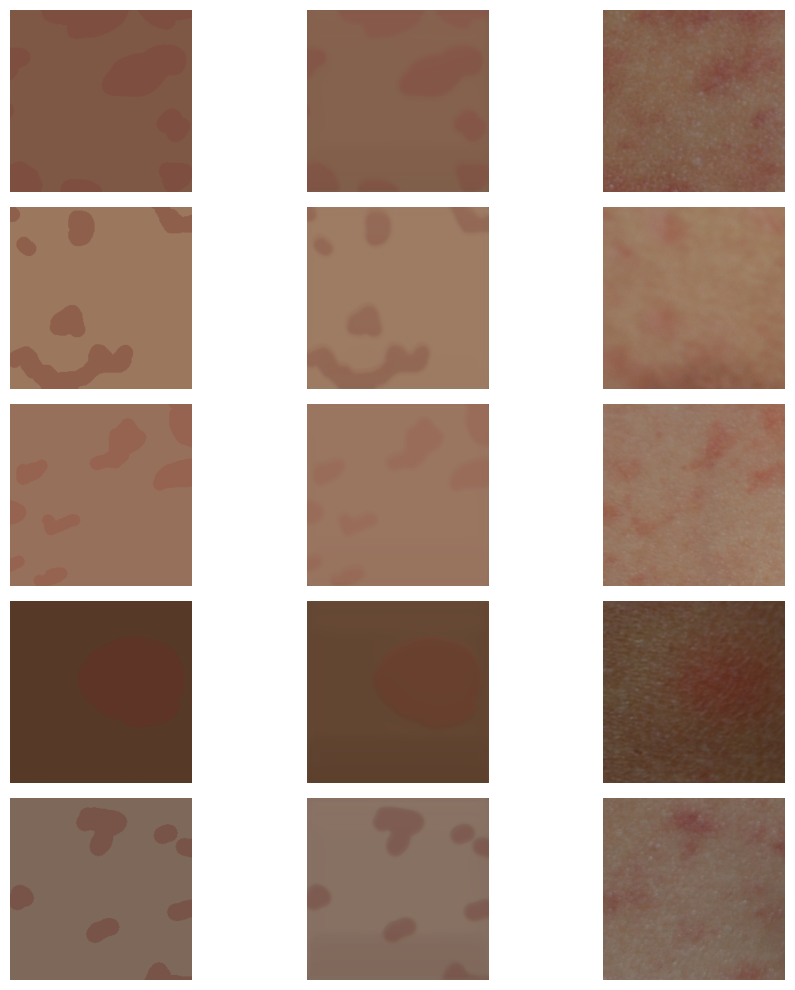

In [18]:
# Visual evaluation
# Take 5 examples, use validation data
device = "cuda"
n_images = 5
for batch in val_dl:
    imgs = batch["img"][:n_images,...]
    masks = batch["mask"][:n_images,...].to(device)

    generator = model.generator.to(device)
    generator.eval()
    with torch.no_grad():
        generated_images = generator(masks)
    
    # Create a figure and subplots with a 5x3 grid
    fig, axes = plt.subplots(n_images, 3, figsize=(10, 10))
    #TODO: Probably fix channel order
    for i in range(generated_images.shape[0]):
        # Mask
        axes[i,0].imshow(np.moveaxis(masks[i,...].cpu().numpy(),0,-1))
        axes[i,0].axis('off')
        # Generated image
        axes[i,1].imshow((np.moveaxis(generated_images[i,...].cpu().numpy(),0,-1)+1)/2)
        axes[i,1].axis('off')
        # Original image
        axes[i,2].imshow((np.moveaxis(imgs[i,...].cpu().numpy(),0,-1)+1)/2)
        axes[i,2].axis('off')

    plt.tight_layout()
    plt.show()
    break

In [11]:
# FID evaluation
# Take all training examples, I know it's overfitting but w.e.
# Instantatiate FID object
device = 'cuda'
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(normalize=True).to(device)

bs = 32

for batch in val_dl:

    generator = model.generator.to(device)
    generator.eval()
    with torch.no_grad():
        generated_images = generator(batch["mask"].to(device))
     
    fid.update(generated_images, real=False)
    fid.update(batch["img"].to(device), real=True)
print(f"FID:{fid.compute()}")

FID:311.8368835449219


## Conclusions

Many possibilities of implementing the GAN and the training data were explored:
- Using both black and white masks as well as color ones
- Different data normalization techniques
- Changing the size of the generator and/or the discriminator
- Running one of the two networks multiple times for each step
- Decreasing the learning rate and training for longer
- Having a PatchGAN discriminator
- Changing the loss, even using a Wasserstein GAN

Despite all these tests the model always collapsed or was unable to converge to sensible outputs or became a blurring filter.  
My explanation on why this happens is the follwing: the model is trying to learn a deterministic mapping (the PIX2PIX paradigm is deterministic) from a starting state to a generated image. However the starting state will often be quite similar despite the output being different (due to different image-taking conditions). When you couple this with the blurry and badly exposed data, it should not come as a surprise that not sensible results are obtained, especially with a GAN, the most delicate model of all.
